<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/simplify-nn-case/04.neural_networks/04.neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you run this on Google Colab, change the environment to TPU or GPU

In [1]:
!pip install -U imblearn

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime # Import the datetime module

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
tf.compat.v1.enable_eager_execution()
import random



!pip install category_encoders
import category_encoders as ce




# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile

from functools import partial

--2025-05-12 16:36:08--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py.3’

visualization.py.3  100%[===================>]  12.72K  --.-KB/s    in 0s      

2025-05-12 16:36:08 (129 MB/s) - ‘visualization.py.3’ saved [13023/13023]



### Mount your Google Drive

Training a neural network may take long time and you don't want to do it every time. Once you've trained a model, it is better to save it, so that you can use it immediately for prediction next times.

Unfortunately, the storage on Google is reset every time. You need to store all persistent data in you Google Drive.

You need therefore to mount your Google Drive, which you will use later in this notebook

In [3]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/04.neural-networks/'

Mounted at /content/gdrive


# Use case description

The use case is from [ComCom19].


**Goal** Estimate bandwidth available between two communicating endpoints.
![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/train-of-packets.png)

**Why**: Knowing the available bandwidth, video streaming clients can properly choose the quality level to request.



Measures
* Bits per seconds sent $r_{\text{in}}$
* Bits per second received $r_\text{out}$



![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/r_in-r_out.png)
\[Figure from [ComCom19] \]


The auhtors set up the following testbed:


![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/testbed.png)


Measures are collected in the **Video Receiver**. All the other machines just produce cross-traffic.

Measures are recorded via an Endace Data Acquisition and Generation (DAG) card, which timestamp all packets in an extremely precise way.

![alt text](https://www.endace.com/assets/images/products/DAG%209.5G4F_angled_small.png)

([Producer website](https://www.endace.com/endace-high-speed-packet-capture-solutions/oem/dag/))



For simplicity, we will just consider the case with a single link between client and server.

# Traces

The description of the dataset can be found in the Appendix of Khangura's [PhD thesis](https://www.repo.uni-hannover.de/bitstream/handle/123456789/9219/Khangura_Sukhpreet_PhD_Thesis.pdf?sequence=3&isAllowed=y). I have already pre-processed the dataset via [this script](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/ignore-preprocessing.ipynb), which you can ignore.

Let's directly download the preprocessed files and transform them into dataframes

In [15]:
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/refs/heads/simplify-nn-case/04.neural_networks/data/X_train.csv
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/refs/heads/simplify-nn-case/04.neural_networks/data/X_test.csv
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/refs/heads/simplify-nn-case/04.neural_networks/data/label_test.csv
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/refs/heads/simplify-nn-case/04.neural_networks/data/label_train.csv

X_train = pd.read_csv('X_train.csv', header=None)
X_test = pd.read_csv('X_test.csv', header=None)
label_test = pd.read_csv('label_test.csv', header=None, names=['label'], dtype=str)
label_train = pd.read_csv('label_train.csv', header=None, names=['label'], dtype=str)



--2025-05-12 16:00:02--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/refs/heads/simplify-nn-case/04.neural_networks/data/X_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105750 (103K) [text/plain]
Saving to: ‘X_train.csv.3’

X_train.csv.3       100%[===================>] 103.27K  --.-KB/s    in 0.01s   

2025-05-12 16:00:02 (8.48 MB/s) - ‘X_train.csv.3’ saved [105750/105750]

--2025-05-12 16:00:03--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/refs/heads/simplify-nn-case/04.neural_networks/data/X_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercon

# Samples and features

In [16]:
X_train.head()

,0,1,2,3,4,5,6,7
0,4.417449,0.588993,0.294497,0.294497,0.294497,0.0,0.0,0.0
1,4.122952,0.588993,0.883490,0.294497,0.000000,0.0,0.0,0.0
2,3.239463,1.472483,0.883490,0.294497,0.000000,0.0,0.0,0.0
3,3.828456,0.588993,0.883490,0.588993,0.000000,0.0,0.0,0.0
4,4.122952,0.883490,0.588993,0.294497,0.000000,0.0,0.0,0.0


Each sample corresponds to an experiment, which is run for some minutes. A sample is described with a vector of 8 numbers, representing the distribution of $r=r_{in}/r_{out}$. These 8 numbers, per each experiment, are obtained as follows:

* First, in each experiment, several measures of $r$ are collected, i.e., at every few milliseconds
* The histogram of such measures is created, with 8 bars
* Each of the 8 values correspond to a bar

In [17]:
label_train.head()

,label
0,50
1,50
2,50
3,50
4,50


The $i$-th element of the vector `label_train` correspond to the bandwidth available during the $i$-th experiment

### Class imbalance

Let's check for class imbalance

In [18]:
label_train.value_counts()

,count
label,
25,400
50,400
12.5,100
37.5,100
75,100


Correct using Synthetic Minority Over-Sampling Technique (SMOTE) (see `03.classification.ipynb`)

In [19]:
smote = SMOTE()
X_train, label_train = smote.fit_resample(X_train, label_train)

label_train.value_counts()

,count
label,
12.5,400
25,400
37.5,400
50,400
75,400


### Scaling
With NN is important to **scale** the dataset

In [20]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('X_train scaled\n', X_train[0:6, :] )

X_train scaled
 [[0.8        0.25       0.14285714 0.16666667 0.16666667 0.
  0.         0.        ]
 [0.73333333 0.25       0.42857143 0.16666667 0.         0.
  0.         0.        ]
 [0.53333333 0.625      0.42857143 0.16666667 0.         0.
  0.         0.        ]
 [0.66666667 0.25       0.42857143 0.33333333 0.         0.
  0.         0.        ]
 [0.73333333 0.375      0.28571429 0.16666667 0.         0.
  0.         0.        ]
 [0.6        0.5        0.42857143 0.16666667 0.         0.
  0.         0.        ]]


### One-hot encoding
**One-hot encode** the target

In [21]:
one_hot_encoder = ce.OneHotEncoder(cols=['label'], use_cat_names='True')
one_hot_encoder.fit(label_train)

OneHotEncoder(cols=['label'], use_cat_names='True')

In [24]:
one_hot_encoder = ce.OneHotEncoder(cols=['label'], use_cat_names='True')
one_hot_encoder.fit(label_train)
y_train = one_hot_encoder.transform(label_train)
y_test  = one_hot_encoder.transform(label_test)

print('y_train', y_train)

num_of_classes = y_train.shape[1]
class_names =list(y_train.columns)
print('There are ', num_of_classes, ' classes. Their names is:', class_names)

y_train       label_50  label_25  label_37.5  label_12.5  label_75
0            1         0           0           0         0
1            1         0           0           0         0
2            1         0           0           0         0
3            1         0           0           0         0
4            1         0           0           0         0
...        ...       ...         ...         ...       ...
1995         0         0           0           0         1
1996         0         0           0           0         1
1997         0         0           0           0         1
1998         0         0           0           0         1
1999         0         0           0           0         1

[2000 rows x 5 columns]
There are  5  classes. Their names is: ['label_50', 'label_25', 'label_37.5', 'label_12.5', 'label_75']


# Build a NN model

To train faster, change the runtime to GPU or TPU.
In the Google Colab menu at the top, do `Runtime > Change Runtime Type` and select GPU or TPU (sometimes GPU is faster than TPU, sometimes it is the opposite; so you can infidderently try either of them).

The following function creates a neural network architecture and compiles it

In [33]:
def make_sequential_model(sample_size, layer_sizes,
                          hidden_activation_function="relu",
                          out_activation_function="softmax",
                          loss_fun="categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 8 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0],
                  input_dim = sample_size) )

  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )

  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )


  model.compile(loss=loss_fun,
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate) ,
              metrics=metrics)

  return model

See Ch.10 of [Ge19] to know more about these hyper-parameters.

Loss function:
* `categorical_crossentropy` is the cross-entropy as we defined in the slides
* In binary classification then use `sigmoid` activation function in the output layer instead of the `softmax` and `binary_crossentropy` loss.

Optimizer:
* We are using Stochastic Gradient Descent with learning rate $\eta=$ `learn_rate`

Metrics:
* We are asking Keras to show at each epoch the accuracy. Note that the accuracy value is ignored during training. This metric is just visualized

As en example, let us instantiate our first neural network

In [34]:
sample_size = X_train.shape[1] # num of columns
shallow_architecture = [8, 6, num_of_classes]
model = make_sequential_model(sample_size, shallow_architecture,
                              learning_rate=0.1)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │            35 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

Let's introduce some operations to make our code **repeatable**: we want to have the same results, every time we run the different neural networks below, no matter the order in which we run them and no matter who runs them.

 To this aim, we use the following tricks:
 * `clear_session()`: it resets the neural network weights. If we do not do so, if we train a certain neural network A and then another neural network B, which may have the same architecture, some of the weights of B are initialized as in A. If we run in the opposite order, some of the weights of A are initialized as in B. Therefore, our results would depend on the order of training, which we do not want. This is why we will use `clear_session`. Actually, this function does even more: it resets all the variables handled by tensorflow. If you do not use it, every time you create a new neural network tensor flow will not remove the previous ones and adds the new one to its set of variables. This can bring to an excessive memory consumption. `clear_session` resets everything, thus solving memory problems.
 * Setting seeds: during training, there is some stochastic operations done: for instance, the validation set is chosen randomly, by default, the batch of samples is selected randomly at each iteration, etc.

More on randomness and reproducibility, on [this ODSC's blog](https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752).

In [35]:
def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more:
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))

This network is probably too big with respect to the small amount of data. However, nobody can tell us, until we see the training results.

**Always experiment with NNs of different sizes**

# Training

In [44]:
def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000,
                overwrite=True, validation_split=0.2, patience=20):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training
            (thanks to the ModelCheckpoint callback (see the implementation
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.

  overwrite: boolean
            If true, the model will be built and trained from scratch,
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the
            specified number of epochs
  """

  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  plot_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # oldcode was `PlotLossesKerasTF()`  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True)


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs,
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb],
                      validation_split=validation_split )

  return history

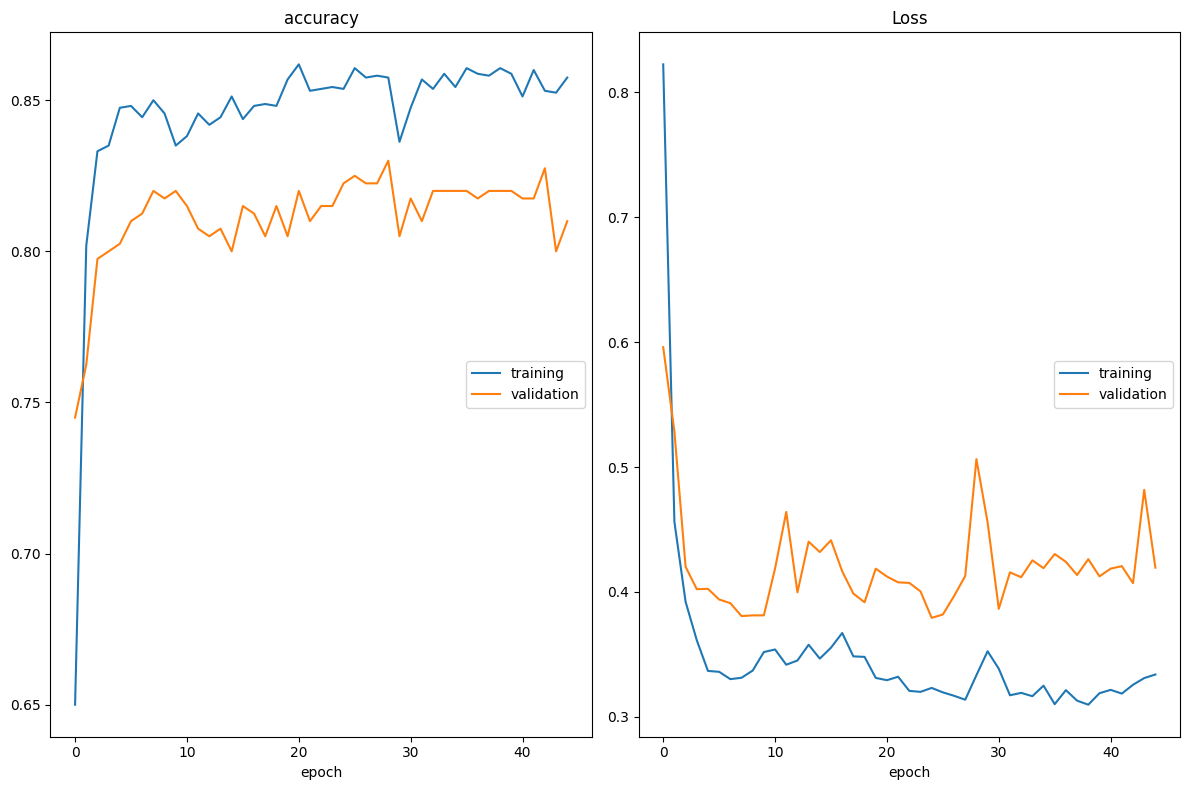

accuracy
	training         	 (min:    0.650, max:    0.862, cur:    0.858)
	validation       	 (min:    0.745, max:    0.830, cur:    0.810)
Loss
	training         	 (min:    0.310, max:    0.822, cur:    0.334)
	validation       	 (min:    0.379, max:    0.596, cur:    0.419)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8578 - loss: 0.3550 - val_accuracy: 0.8100 - val_loss: 0.4194
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 25.


In [37]:
nn_file = my_path + 'nn-0.1.h5'

history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

Note that training ended before the 200 epochs specified as `max_epochs`. This is because we set the value of `patience` to 20: since for 20 consecutive epochs the validation loss was not improving, we aborted training, to avoid wasting time.

In any case, our NN does has not managed to converge. This is often due to the **learning rate being too large**. In our case, it was 0.1. Let's try a smaller one.

In [38]:
model = make_sequential_model(sample_size, shallow_architecture,
                              learning_rate=0.001)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


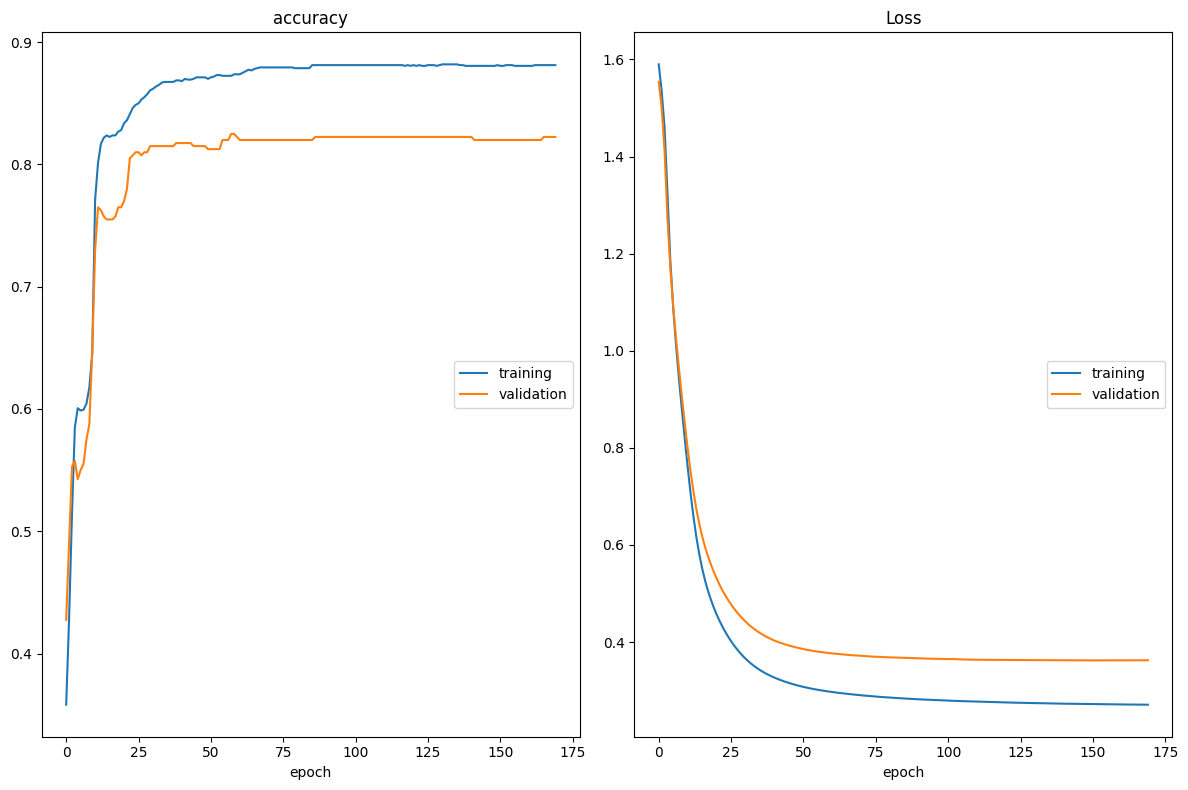

accuracy
	training         	 (min:    0.358, max:    0.882, cur:    0.881)
	validation       	 (min:    0.428, max:    0.825, cur:    0.822)
Loss
	training         	 (min:    0.271, max:    1.590, cur:    0.271)
	validation       	 (min:    0.362, max:    1.554, cur:    0.363)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8775 - loss: 0.2829 - val_accuracy: 0.8225 - val_loss: 0.3626
Epoch 170: early stopping
Restoring model weights from the end of the best epoch: 150.


In [39]:
nn_file = my_path + 'nn-0.001.h5'

history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

Much better now. Let's try with a much smaller one.

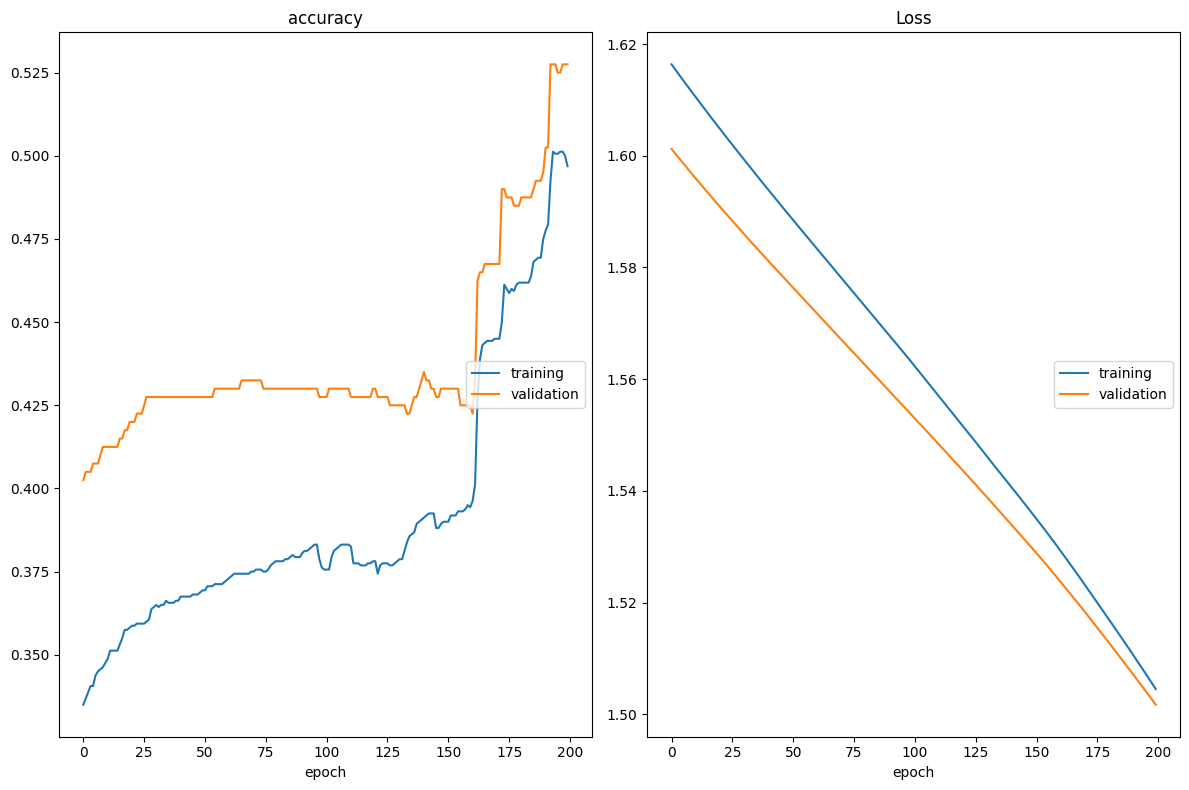

accuracy
	training         	 (min:    0.335, max:    0.501, cur:    0.497)
	validation       	 (min:    0.403, max:    0.527, cur:    0.527)
Loss
	training         	 (min:    1.505, max:    1.616, cur:    1.505)
	validation       	 (min:    1.502, max:    1.601, cur:    1.502)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4664 - loss: 1.5147 - val_accuracy: 0.5275 - val_loss: 1.5017
Restoring model weights from the end of the best epoch: 200.


In [40]:
nn_file = my_path + 'nn-0.00001.h5'
model = make_sequential_model(sample_size, shallow_architecture,
                              learning_rate=0.00001)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

The loss decreases too slowly
. Let's try a learning rate in the middle

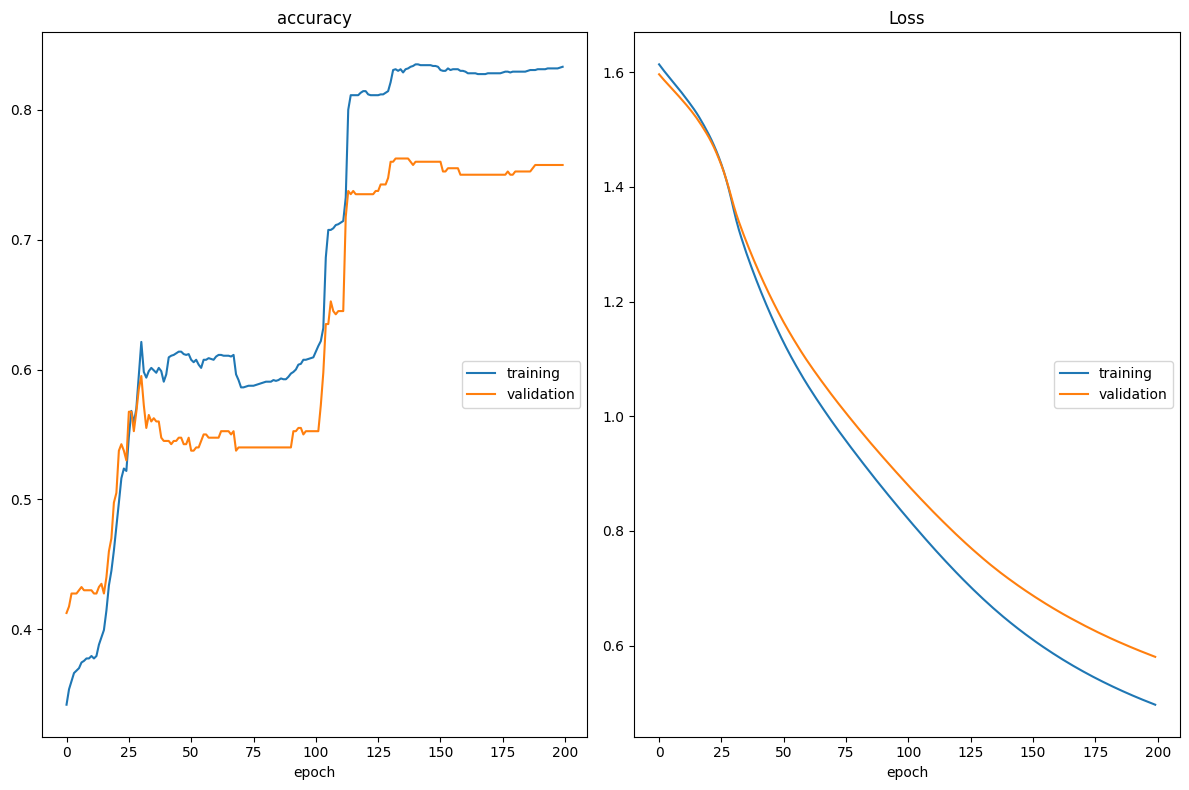

accuracy
	training         	 (min:    0.342, max:    0.835, cur:    0.833)
	validation       	 (min:    0.412, max:    0.762, cur:    0.757)
Loss
	training         	 (min:    0.497, max:    1.614, cur:    0.497)
	validation       	 (min:    0.581, max:    1.596, cur:    0.581)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8385 - loss: 0.5035 - val_accuracy: 0.7575 - val_loss: 0.5805
Restoring model weights from the end of the best epoch: 200.


In [41]:
nn_file = my_path + 'nn-0.0001.h5'
model = make_sequential_model(sample_size, shallow_architecture,
                              learning_rate=0.0001)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

Let's try with learning rate 0.01

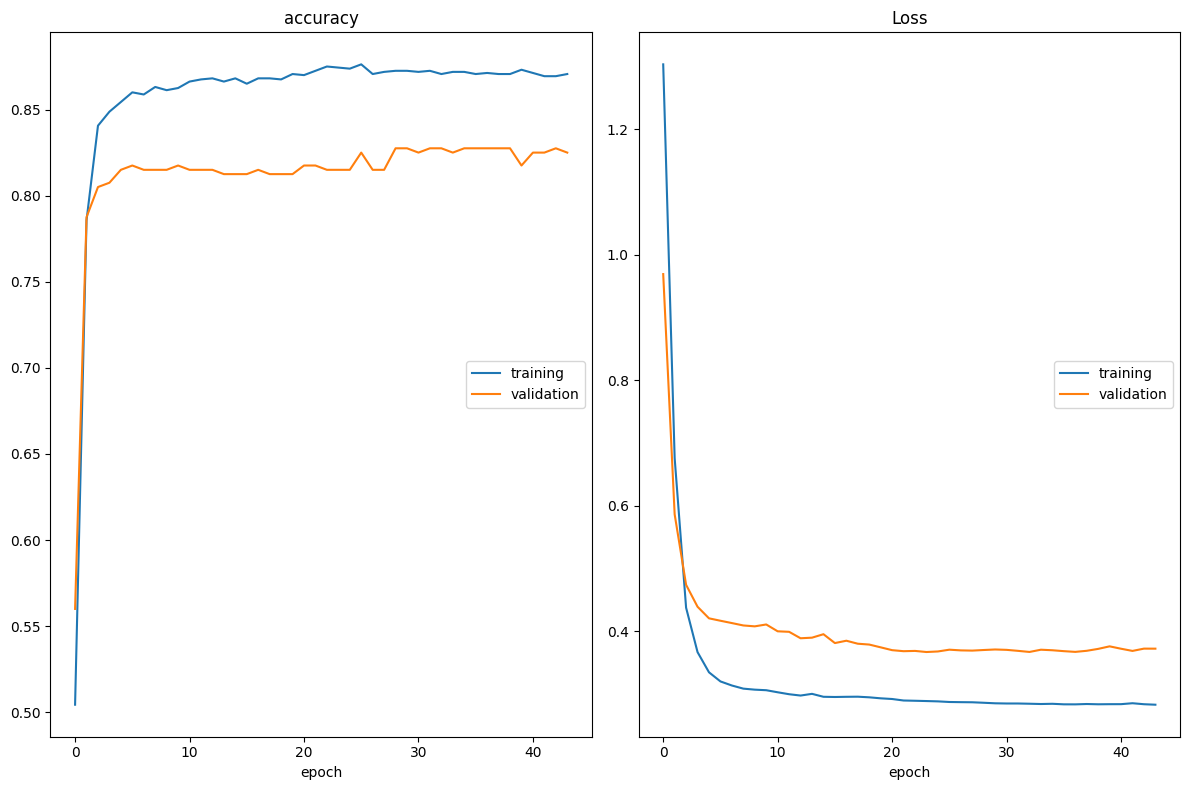

accuracy
	training         	 (min:    0.504, max:    0.876, cur:    0.871)
	validation       	 (min:    0.560, max:    0.827, cur:    0.825)
Loss
	training         	 (min:    0.283, max:    1.303, cur:    0.283)
	validation       	 (min:    0.367, max:    0.969, cur:    0.372)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8636 - loss: 0.2940 - val_accuracy: 0.8250 - val_loss: 0.3719
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 24.


In [42]:
nn_file = my_path + 'nn-0.01.h5'
model = make_sequential_model(sample_size, shallow_architecture,
                              learning_rate=0.01)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

## Recover the best model

Observing the validation loss curves, it seems that learning rate 0.01 is the best.

Let us thus recover the model with 0.001. Remember that our code saves automatically all the models. Therefore, we can load the already trained model from the respective file.

We also do some additional 300 epochs of training. Note that we do not start training from scratch, since the initial NN weights are the ones that we had at the end of the previous training, just before saving the model in the file. You have thus understood that saving models in files is a good practice, because we can also improve such models over and over again, even several days after our last training.

To load a previously existing model, we specify `overwrite=False`.

In [49]:
nn_file = my_path + 'nn-0.01.h5'
model = make_sequential_model(sample_size, shallow_architecture,
                              learning_rate=0.01, )
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=300,
                      overwrite=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loading pre-existing model
Epoch 1/300


NotImplementedError: numpy() is only available when eager execution is enabled.

Don't be mislead by the zoom! The model seems visually more "instable" than when we have saved it, but it is not. If you look at the y-axis, you can notice they are zoomed in a very small interval. So, oscillations seem big, but they are actually very small.

# Prediction

Let's use the model for prediction.

In [ ]:
nn_file = my_path + 'nn-0.01.h5'
model = load_model(nn_file)

Get the probability for each sample of being in a class.

In [ ]:
y_proba = model.predict(X_test)
print( 'y_proba\n', y_proba)

y_proba
 [[9.22338128e-01 7.76384026e-02 2.44821379e-34 2.03527475e-06
  2.14824086e-05]
 [3.84003222e-01 6.12566590e-01 1.04349002e-24 3.40797543e-03
  2.22973449e-05]
 [8.57363045e-01 1.42633662e-01 0.00000000e+00 1.37415645e-06
  1.97442159e-06]
 ...
 [8.60821187e-01 1.39157906e-01 7.91317175e-34 7.13554164e-06
  1.37054485e-05]
 [2.26822063e-01 7.69561052e-01 2.20383355e-27 3.61391995e-03
  2.92435357e-06]
 [7.02998564e-02 9.26454961e-01 2.96887467e-32 3.24504776e-03
  6.13408560e-08]]


The predicted class of each sample is the one with the highest probability.

In [ ]:
pred_proba = model.predict(X_test)
pred_label = np.argmax(pred_proba,axis=1)
print( 'pred_label\n', pred_label )

pred_label
 [0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1
 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 2 1 2 2 2 2 2 3 1 2 1
 2 2 2 2 2 2 1 2 2 2 1 1 2 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 2 2 1 1 1 2 2 2 1
 1 2 1 2 2 3 3 3 2 2 1 1 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 1 2
 1 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 2 3 3 1 3 1 1 1 1 3 3 3 3 3 1 3 3 3 1 1 1 1 1 3 1 3 3 1 3 1 3 3 3 1
 1 3 1 1 3 1 1 3 1 1 1 1 1 3 1 1 1 1 1 3 3 1 3 1 1 1 1 1 3 1 1 1 3 1 3 1 1
 3 3 3 1 1 1 1 1 1 1 1 3 3 1 1 1 3 1 1 1 1 1 1 1 3 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The best way to evaluate the model is the confusion matrix

In [ ]:
y_test.values

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

We need to convert one-hot-encoded values to numerical labels

In [ ]:
true_label = np.argmax(y_test.values, axis=1)
true_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Normalized confusion matrix
[[0.87666667 0.12333333 0.         0.        ]
 [0.12166667 0.54       0.26166667 0.07666667]
 [0.         0.01       0.99       0.        ]
 [       nan        nan        nan        nan]]


/content/visualization.py:123: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


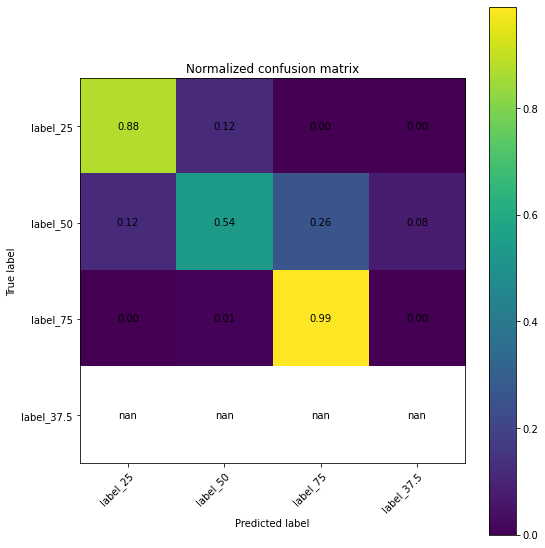

In [ ]:
plot_conf_mat(true_label, pred_label, np.array(class_names) )

In [ ]:
print("The names of the classes are ", class_names)
print("The true classes found in the test set are ", Counter(true_label) )
print("The predicted classes are ", Counter(pred_label) )

The names of the classes are  ['label_25', 'label_50', 'label_75', 'label_37.5', 'label_12.5']
The true classes found in the test set are  Counter({1: 600, 0: 300, 2: 100})
The predicted classes are  Counter({1: 362, 0: 336, 2: 256, 3: 46})


Observe that class `3`, i.e., `label_37.5` is predicted by the model but does not appear in the test set. This is why it appear as `nan` in the confusion matrix.

Observe also that class `4`, i.e., `label_12.5` does not appear neither in the true labels of the test set, nor in the predicted labels. For this reason it does not appear in the confusion matrix.

In [ ]:
print( classification_report(true_label, pred_label, labels=[0,1,2,3,4],
                             target_names=class_names) )

              precision    recall  f1-score   support

    label_25       0.78      0.88      0.83       300
    label_50       0.90      0.54      0.67       600
    label_75       0.39      0.99      0.56       100
  label_37.5       0.00      0.00      0.00         0
  label_12.5       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69      1000
   macro avg       0.41      0.48      0.41      1000
weighted avg       0.81      0.69      0.71      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Deeper architecture

Let us now try a deeper neural network and check if it is better.

In [ ]:
deep_architecture = [8, 8 ,8, 8, 8, 8, 8, 8, 8, num_of_classes]

In [ ]:
model = make_sequential_model(sample_size, deep_architecture,
                              learning_rate=0.01)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 7

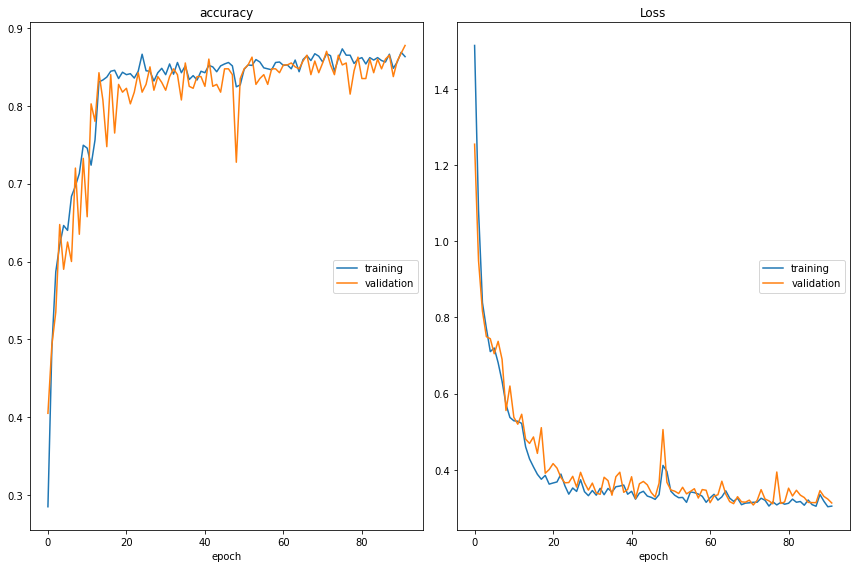

accuracy
	training         	 (min:    0.285, max:    0.873, cur:    0.863)
	validation       	 (min:    0.405, max:    0.877, cur:    0.877)
Loss
	training         	 (min:    0.303, max:    1.514, cur:    0.305)
	validation       	 (min:    0.308, max:    1.255, cur:    0.313)
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping


In [ ]:
nn_file = my_path + 'nn-deep-lr_0.01.h5'
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=300)

It has not converged. With such a deep neural network, we might need a **smaller learning rate**.

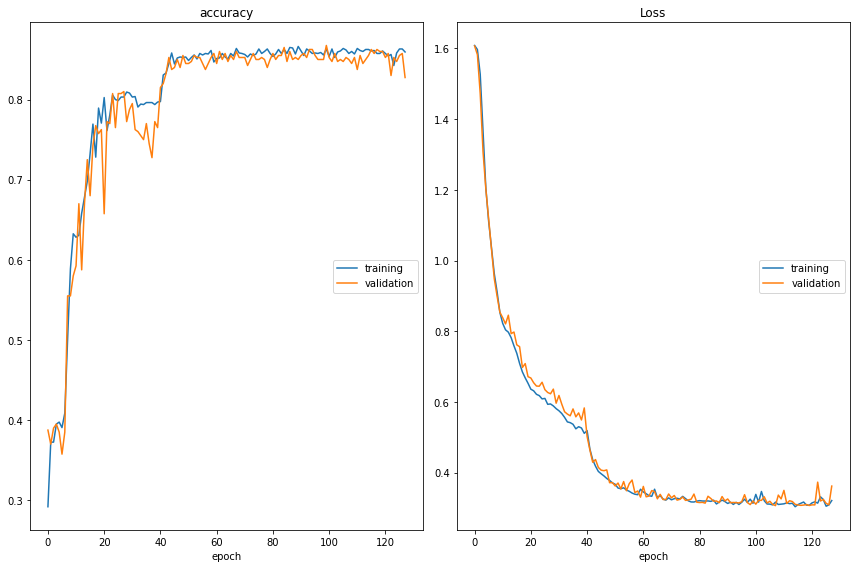

accuracy
	training         	 (min:    0.292, max:    0.866, cur:    0.859)
	validation       	 (min:    0.357, max:    0.868, cur:    0.827)
Loss
	training         	 (min:    0.303, max:    1.609, cur:    0.321)
	validation       	 (min:    0.306, max:    1.607, cur:    0.362)
Restoring model weights from the end of the best epoch.
Epoch 00128: early stopping


In [ ]:
nn_file = my_path + 'nn-deep-lr_0.001.h5'
model = make_sequential_model(sample_size, deep_architecture,
                              learning_rate=0.001)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

Or even smaller

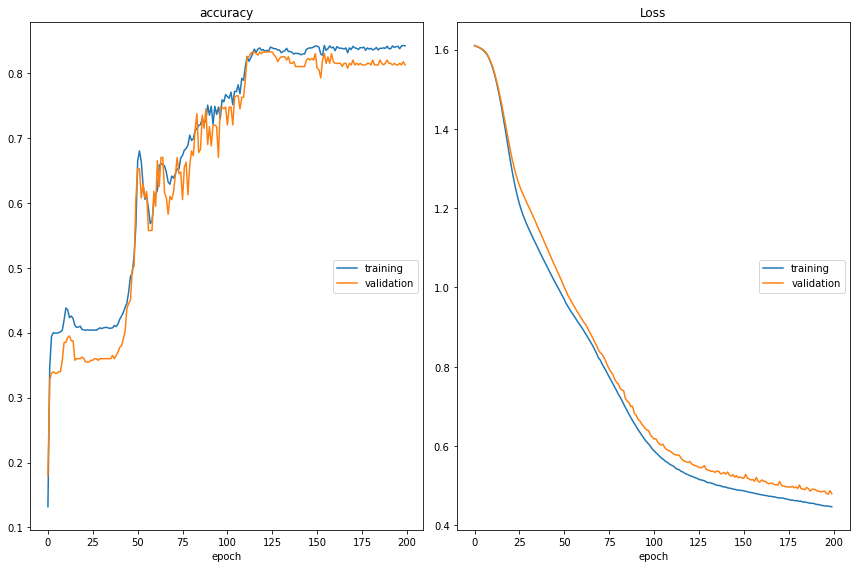

accuracy
	training         	 (min:    0.132, max:    0.842, cur:    0.842)
	validation       	 (min:    0.180, max:    0.832, cur:    0.812)
Loss
	training         	 (min:    0.447, max:    1.610, cur:    0.447)
	validation       	 (min:    0.478, max:    1.609, cur:    0.480)


In [ ]:
nn_file = my_path + 'nn-deep-lr_0.0001.h5'
model = make_sequential_model(sample_size, deep_architecture,
                              learning_rate=0.0001)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

The validation loss was still decreasing. Maybe if we continue training, we can further improve the validation loss. Let's try to resume the training where we have left it, by using `overwrite=False`

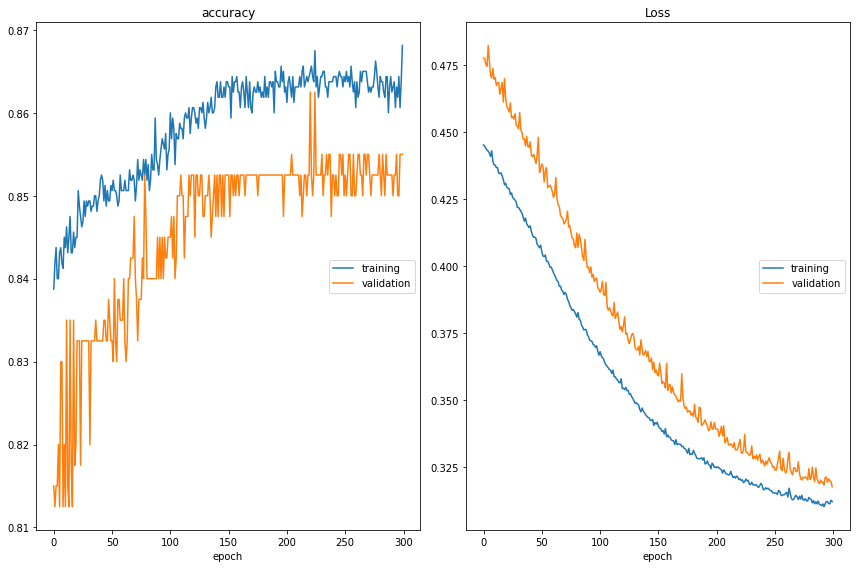

accuracy
	training         	 (min:    0.839, max:    0.868, cur:    0.868)
	validation       	 (min:    0.812, max:    0.863, cur:    0.855)
Loss
	training         	 (min:    0.310, max:    0.445, cur:    0.312)
	validation       	 (min:    0.318, max:    0.482, cur:    0.318)


In [ ]:
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=300,
                      overwrite=False)

Let's furthur continue

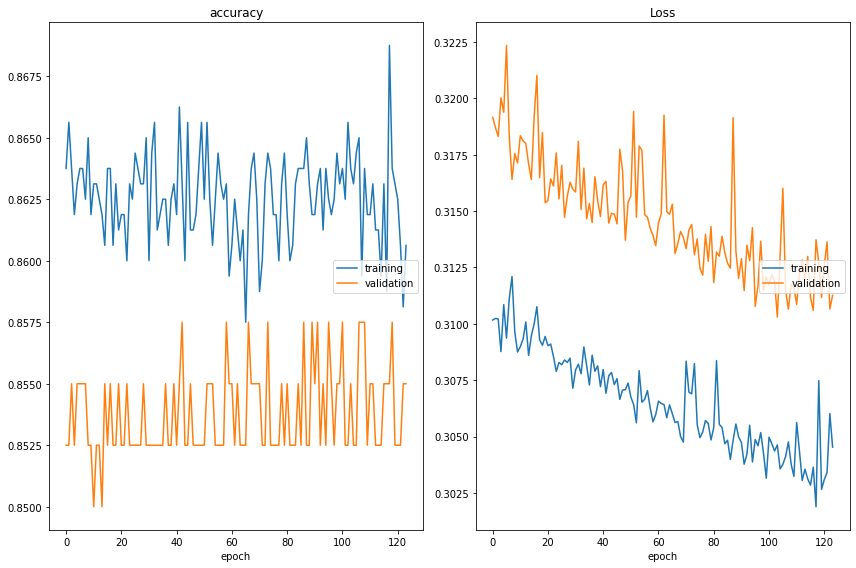

accuracy
	training         	 (min:    0.858, max:    0.869, cur:    0.861)
	validation       	 (min:    0.850, max:    0.858, cur:    0.855)
Loss
	training         	 (min:    0.302, max:    0.312, cur:    0.305)
	validation       	 (min:    0.310, max:    0.322, cur:    0.311)
Restoring model weights from the end of the best epoch.
Epoch 00124: early stopping


In [ ]:
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=300,
                      overwrite=False)

After 800 epochs of training for the `deep_architecture`, the validation loss remain higher than with a smaller neural network. We may further improve `deep_architecture by keep searching for a better learning rate, using regularization, etc. All these things are worth trying, but take time.

This shows that, although a deeper neural network is more powerfull than a shallower one, in practice it may difficult and time-consuming to train. In that case, using a shallower neural network is better.

Suggestion: do not start directly with deep and big networks. Start shallow and narrow, and increase after (and gradually).

# Further improvements

We still need to improve. You can play with hyper-parameters (see slides):
* Try other architectures (more shallow, even deeper, larger (each layer having a lot of neurons), narrower (each layer having few neurons), etc.
* Regularize (use the parameter `regularization_coeff` of the function `make_sequential` defined in this noteboook)
* Change the optimizer
* Change the activation functions
* Change the batch size (default in `model.fit(..)` is 32)

# Limits of the work

* Only a finite set of available bandwidth values are used (12.5, 25, 37.5, 50, 75 Mbps). In reality, any value can occur => Need to extend the test and validation test with random bandwidth values.
* Is the method precise also when the total capacity is not 100 Mbps?

# Regression
We have so far only used neural network to perform classification. It is also possible to perform regression. To do so, the code remains essentially the same, just change the last layer: instead of `softmax`, put `Dense(1)` (see pagg. 307-308 of [Ge19]).



# References

* [ComCom19] Khangura, S. K., Fidler, M., & Rosenhahn, B. (2019). Machine learning for measurement-based bandwidth estimation. Computer Communications, 144(1), 18–30.
* [Ge19] Geron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2019, O'Reilly
* [KhConf19] Khangura, S. K. (2019). Neural Network-based Available Bandwidth Estimation from TCP Sender-side Measurements. In IEEE/IFIP PEMWN.
* [KhThesis19] Khangura, S. K. (2019). Machine Learning-based Available Bandwidth Estimation. Leibniz University.